## Ridge Regression with K-fold Cross validation

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
import random
%matplotlib inline

In [18]:
data = scio.loadmat('HW1_Data/dataset2')

In [19]:
def transform(X, degree):
    Z = A = X
    for i in range(degree-1):
        Z = Z * A
        X = np.insert(X, [i+1], Z, axis=1)
    return np.insert(X, 0, 1, axis=1)

In [20]:
X_train = data['X_trn']
y_train = data['Y_trn']
X_test = data['X_tst']
y_test = data['Y_tst']

X_train_2 = np.matrix(transform(X_train, 2))
X_train_3 = np.matrix(transform(X_train, 3))
X_train_5 = np.matrix(transform(X_train, 5))

X_test_2 = np.matrix(transform(X_test, 2))
X_test_3 = np.matrix(transform(X_test, 3))
X_test_5 = np.matrix(transform(X_test, 5))

y_train = np.matrix(y_train)
y_test = np.matrix(y_test)

theta0_2 = np.matrix(np.zeros(3))
theta0_3 = np.matrix(np.zeros(4))
theta0_5 = np.matrix(np.zeros(6))

alpha = 0.01
batchSize = 15
threshold = 0.001

In [21]:
def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

In [22]:
def MSE(y, y_pred):
    y = np.asarray(y)
    y_pred = np.asarray(y_pred)
    return np.mean((y - y_pred) ** 2)

In [23]:
def ridgeClosedForm(X, y, l):
    lI = l * np.identity(X.shape[1])
    return (X.T * X + lI).I * (X.T * y)

In [31]:
def plotPrediction(y, y_pred, title = 'train set'):
    plt.scatter(y, y_pred)
    plt.plot([min(y), max(y)], [min(y), max(y)], '--')
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.title(title)

In [24]:
def ridgeGradientDescent(X, y, theta, alpha, minibatch_size, threshold, l):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = theta.ravel().shape[1]
    cost = [np.inf]
    i = 1

    while True:
        for k in range(len(X) // minibatch_size):
            index_list = np.random.choice(len(X), size=minibatch_size, replace=False)
            X_batch = X[index_list]
            y_batch = y[index_list]
            error = (X_batch * theta.T) - y_batch
            
            for j in range(parameters):
                term = np.multiply(error, X_batch[:,j]) + np.multiply(l, theta)
                temp[0,j] = theta[0,j] - ((alpha / len(X_batch)) * np.sum(term))

            theta = temp
            
        cost.append(computeCost(X, y, theta))
        if cost[-2] - cost[-1] < threshold and cost[-2] - cost[-1] > 0:
            break
            
#         if i % 50 == 0:
#             print("Loss iter",i,": ",cost[-1])
#         i += 1
        
        
    return theta, cost

In [25]:
def kFoldCV(X, y, fold):
    lam = np.arange(0.01, 0.1, 0.01)
    cost_lam = {}
    for l in lam:
        cost = 0
        for i in range(0,fold-1):
            data = np.concatenate((X, y), axis=1)
            data_split = np.split(data, fold)
            data1 = data_split[:i]
            data2 = data_split[i+1:]
            if not data1:
                data_train = np.concatenate((data2[:]), axis=0)
            else:
                data_train = np.concatenate((data1,data2), axis=0)
                data_train = np.concatenate((data_train[:]), axis=0)
            data_hold = data_split[i]
            cols = data_train.shape[1]
            X_train = np.matrix(data_train[:, 0:cols - 1])
            y_train = np.matrix(data_train[:, cols - 1:cols])
            theta = ridgeClosedForm(X_train, y_train, l)
            X_hold = np.matrix(data_hold[:, 0:cols - 1])
            y_hold = np.matrix(data_hold[:, cols - 1:cols])
            theta = theta.T
            cost = cost + computeCost(X_hold, y_hold, theta)
        avg_cost= cost/fold
        cost_lam[l] = avg_cost
        best_lam = min(cost_lam, key=lambda k: cost_lam[k])
    return best_lam

In [36]:
def printer(X_train, y_train, X_test, y_test, fold, teta, size, threshold, degree, alpha):
    print("For K="+str(fold))
    lam = kFoldCV(X_train, y_train, fold)
    theta_2_closed_form = ridgeClosedForm(X_train, y_train, lam)
    theta_2_gd, cost_2_gd = ridgeGradientDescent(X_train, y_train, teta, alpha, size, threshold, lam)
    print("theta closed form", theta_2_closed_form.T)
    print("theta gradient descent", theta_2_gd)
    print("Lambda for degree k=2:", lam)
    print("-------TRAINING SET-------")
    print("cost closed form", computeCost(X_train, y_train, theta_2_closed_form.T))
    print("cost gradient descent", cost_2_gd[-1])
    print("MSE closed form", MSE(y_train, (X_train * theta_2_closed_form)))
    print("MSE train gradient descent", MSE(y_train, (X_train * theta_2_gd.T)))
    print("-------TEST SET-------")
    print("MSE closed form", MSE(y_test, (X_test * theta_2_closed_form)))
    print("MSE test gradient descent", MSE(y_test, (X_test * theta_2_gd.T)))
    plotPrediction(np.asarray(y_train), np.asarray(X_train * theta_2_gd.T))
    plotPrediction(np.asarray(y_test), np.asarray(X_test * theta_2_gd.T))
    print("-------------------------------------------------------------------")

-------FOR DEGREE 2------
For K=2
theta closed form [[ 30.59412838  13.49747999  -0.32388607]]
theta gradient descent [[ 27.92921062  13.4090488   -0.23172263]]
Lambda for degree k=2: 0.09
-------TRAINING SET-------
cost closed form 434.104144581
cost gradient descent 436.149255621
MSE closed form 868.208289162
MSE train gradient descent 872.298511242
-------TEST SET-------
MSE closed form 1746.52410917
MSE test gradient descent 1751.23607249
-------------------------------------------------------------------
For K=10
theta closed form [[ 30.59412838  13.49747999  -0.32388607]]
theta gradient descent [[ 26.72430027  13.5259451   -0.21595662]]
Lambda for degree k=2: 0.09
-------TRAINING SET-------
cost closed form 434.104144581
cost gradient descent 437.467763386
MSE closed form 868.208289162
MSE train gradient descent 874.935526773
-------TEST SET-------
MSE closed form 1746.52410917
MSE test gradient descent 1768.28451793
---------------------------------------------------------------

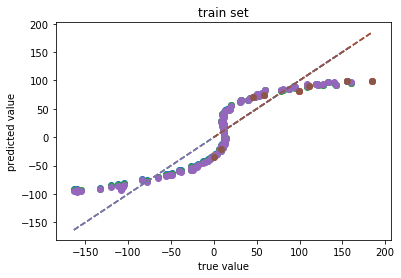

In [37]:
print("-------FOR DEGREE 2------")
printer(X_train_2, y_train, X_test_2, y_test, 2, theta0_2, batchSize, threshold, 2, 0.0001)
printer(X_train_2, y_train, X_test_2, y_test, 10, theta0_2, batchSize, threshold, 2,0.0001)
printer(X_train_2, y_train, X_test_2, y_test, X_train_2.shape[0], theta0_2, batchSize, threshold, 2, 0.0001)




-------FOR DEGREE 3------
For K=2
theta closed form [[ 9.84407892 -0.86029913  1.40252111  0.51036454]]
theta gradient descent [[ 6.03124036 -1.30760573  1.56369753  0.5297146 ]]
Lambda for degree k=2: 0.09
-------TRAINING SET-------
cost closed form 22.1259120841
cost gradient descent 24.6960543252
MSE closed form 44.2518241682
MSE train gradient descent 49.3921086503
-------TEST SET-------
MSE closed form 210.533001781
MSE test gradient descent 207.316308727
-------------------------------------------------------------------
For K=10
theta closed form [[ 9.84407892 -0.86029913  1.40252111  0.51036454]]
theta gradient descent [[ 4.25956031 -1.48897527  1.62316571  0.53575602]]
Lambda for degree k=2: 0.09
-------TRAINING SET-------
cost closed form 22.1259120841
cost gradient descent 27.6212306083
MSE closed form 44.2518241682
MSE train gradient descent 55.2424612167
-------TEST SET-------
MSE closed form 210.533001781
MSE test gradient descent 217.680095145
------------------------

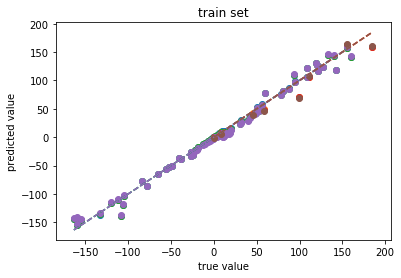

In [38]:
print("\n\n")
print("-------FOR DEGREE 3------")
printer(X_train_3, y_train, X_test_3, y_test, 2, theta0_3, batchSize, threshold, 3, 0.00001)
printer(X_train_3, y_train, X_test_3, y_test, 10, theta0_3, batchSize, threshold, 3, 0.00001)
printer(X_train_3, y_train, X_test_3, y_test, X_train_3.shape[0], theta0_3, batchSize, threshold, 3, 0.00001)




-------FOR DEGREE 5------
For K=2
theta closed form [[  1.07331711e+01   1.05149348e-01   1.13048434e+00   4.14649533e-01
    9.18398999e-03   2.00833748e-03]]
theta gradient descent [[ 0.00562329  0.01113941  0.02237419  0.1793333   0.06281211  0.01019624]]
Lambda for degree k=2: 0.01
-------TRAINING SET-------
cost closed form 21.1855944191
cost gradient descent 91.583435476
MSE closed form 42.3711888382
MSE train gradient descent 183.166870952
-------TEST SET-------
MSE closed form 208.690966099
MSE test gradient descent 654.017857376
-------------------------------------------------------------------
For K=10
theta closed form [[  1.07331711e+01   1.05149348e-01   1.13048434e+00   4.14649533e-01
    9.18398999e-03   2.00833748e-03]]
theta gradient descent [[ 0.00365007  0.00896494  0.01303201  0.14606698  0.06466766  0.01102534]]
Lambda for degree k=2: 0.01
-------TRAINING SET-------
cost closed form 21.1855944191
cost gradient descent 95.9652532036
MSE closed form 42.3711888382

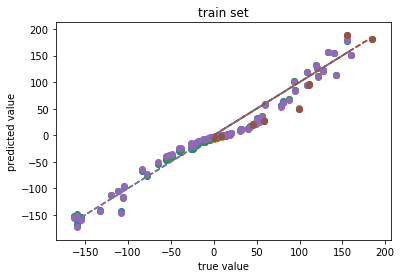

In [39]:
print("\n\n")
print("-------FOR DEGREE 5------")
printer(X_train_5, y_train, X_test_5, y_test, 2, theta0_5, batchSize, 0.0001, 5, 0.000000001)
printer(X_train_5, y_train, X_test_5, y_test, 10, theta0_5, batchSize, 0.0001, 5, 0.000000001)
printer(X_train_5, y_train, X_test_5, y_test, X_train_5.shape[0], theta0_5, batchSize, 0.0001, 5, 0.000000001)